In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import DenseNet121
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [2]:
folder_images = "/content/drive/My Drive/animal_dataset/sheep"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

print('resolusi pada dataset :\n',size_images)

resolusi pada dataset :
 {'OIP-gwB4LOq78ZFZR9oIDU2piAHaE8.jpeg': {'width': 300, 'heigth': 200}, 'OIP-UAxBg6XuoHLftn21IsUXkgHaFj.jpeg': {'width': 300, 'heigth': 225}, 'OIP-J_pblc1OGhJ5iaKUaBgrGgHaFs.jpeg': {'width': 300, 'heigth': 231}, 'OIP-XCosQ3aUb80kxgfaZKWNsgHaDU.jpeg': {'width': 300, 'heigth': 135}, 'OIP-bMGgfcILevTLmMFN9ywTfgHaHs.jpeg': {'width': 290, 'heigth': 300}, 'OIP-gkT7c6jBEq1_A3BJBKyAVgAAAA.jpeg': {'width': 287, 'heigth': 218}, 'OIP-ryOkQGTm6HeG1kX2G0Z7JwAAAA.jpeg': {'width': 160, 'heigth': 240}, 'OIP-aerdB6H35_73yd8RLwu3WQHaE7.jpeg': {'width': 300, 'heigth': 200}, 'OIP-WWBWlBKPAuhxuhCPKQwEhwHaE8.jpeg': {'width': 300, 'heigth': 200}, 'OIP-z4Sh4W1KnyzhQcQ0d-i7dgAAAA.jpeg': {'width': 300, 'heigth': 225}, 'OIP-Lv3VcRAo2kbEFCFWjD38xQHaEK.jpeg': {'width': 300, 'heigth': 169}, 'OIP-X8wnH2QcpVRn_MCRQZhVyAHaDf.jpeg': {'width': 300, 'heigth': 142}, 'OIP-ilh15TiQNjr00jzKVaMmRAHaFj.jpeg': {'width': 300, 'heigth': 225}, 'OIP-mOE7XpxGMIkh7wZkUnRJSAHaGL.jpeg': {'width': 300, 'heigth': 

In [3]:
train_dir = '/content/drive/My Drive/animal_dataset'
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2) # set validation split)

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32, 
        class_mode='categorical',
        subset='validation')

Found 11699 images belonging to 4 classes.
Found 2923 images belonging to 4 classes.


In [5]:
total_train=len(train_generator)
total_val=len(validation_generator)

print("Total training data batches : ", total_train)
print("Total validation data batches: ", total_val)

Total training data batches :  366
Total validation data batches:  92


In [6]:
densenet = DenseNet201(weights='imagenet',
                  include_top=False,input_shape=(150,150,3))


model = tf.keras.Sequential([
    densenet,
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 128)         2211968   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [7]:
import tensorflow as tf
opt = tf.keras.optimizers.SGD(lr=1e-4,momentum=0.99)
opt1 = tf.keras.optimizers.Adam(lr=2e-4)
opt2 = tf.keras.optimizers.RMSprop(momentum=0.99)
opt3 = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=opt3,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92)&(logs.get('val_accuracy')>0.92):
      print("\nAkurasi dan val_accuracy telah mencapai >92%!")
      self.model.stop_training = True
stop_train = myCallback()

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size, 
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//validation_generator.batch_size,
                    epochs=50,
                    callbacks=[stop_train,lr_reduction])

Epoch 1/50
365/365 [==============================] - 150s 410ms/step - loss: 1.0274 - accuracy: 0.6511 - val_loss: 8.4114 - val_accuracy: 0.4145
Epoch 2/50
365/365 [==============================] - 140s 383ms/step - loss: 0.5749 - accuracy: 0.8161 - val_loss: 0.4395 - val_accuracy: 0.8458
Epoch 3/50
365/365 [==============================] - 137s 375ms/step - loss: 0.4278 - accuracy: 0.8633 - val_loss: 0.4276 - val_accuracy: 0.8523
Epoch 4/50
365/365 [==============================] - 136s 372ms/step - loss: 0.3542 - accuracy: 0.8826 - val_loss: 0.5002 - val_accuracy: 0.8187
Epoch 5/50
365/365 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8923
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
365/365 [==============================] - 134s 368ms/step - loss: 0.3299 - accuracy: 0.8923 - val_loss: 1.0450 - val_accuracy: 0.6834
Epoch 6/50
365/365 [==============================] - 136s 372ms/step - loss: 0.2307 - accuracy: 0.9232 -

In [10]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp6svb7a2_/assets


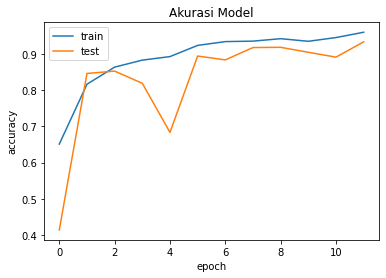

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

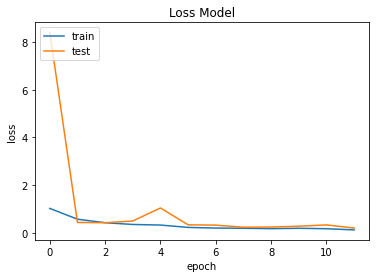

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()